# Building a Quantum Generative Adversarial Network (qGAN) from First Principles

In this notebook I'm piecing together a Quantum Generative Adversarial Network (qGAN) from scratch. I'll start by refreshing the basics of classical GANs and then point out what changes when you replace the generator with a quantum circuit. I'll show you how to take a continuous probability distribution and map it onto a set of qubits by discretising it. Then I'll build a simple variational circuit to serve as the generator, wrap it in Qiskit's `SamplerQNN` and `TorchConnector` so it plays nicely with PyTorch, and pair it with a small classical discriminator. Along the way I'll explain how to draw real and fake samples and how to monitor various divergences (KL, JS, total variation, and friends) during training. Finally I'll hack together a training loop and take stock of how well the learned model matches the target distribution. There are plenty of rabbit holes here; I'll try to leave pointers to interesting extensions.


## 1. Generative Adversarial Networks

Before we go quantum it's worth reminding ourselves what a vanilla GAN does. A *Generative Adversarial Network* consists of two neural nets locked in a game:

- **Generator (G)** takes random noise and spits out synthetic samples, trying to mimic the real data.
- **Discriminator (D)** takes a sample and returns a probability that it came from the true distribution rather than from the generator.

These networks train together in a minimax setup: D learns to tell real from fake, while G learns to fool D. When everything goes well, G ends up approximating the true data distribution.

### Quantum GANs

So what happens if we quantise the generator? In a **quantum GAN (qGAN)** the generator is a parameterised quantum circuit. Measuring this circuit gives one of \(2^n\) bitstrings, and the probability of each outcome is the squared amplitude of the state. By tweaking the circuit's angles we can shape these probabilities to match a target distribution. We still use a classical discriminator to label samples as real or fake. When I first read about qGANs this mapping felt a bit abstract, but once you see it implemented it becomes quite intuitive.


## 2. Discretising Continuous Distributions

Quantum circuits can only output discrete bitstrings, so to learn a continuous distribution we need to put it on a finite grid. Here's the trick: pick an interval \([x_{\min}, x_{\max}]\) that covers most of the probability mass, chop it into \(2^n\) bins (one per computational basis state), and treat the bin centres as our training points. The target PMF is just the integral of the density over each bin, normalised so everything sums to one. There's a trade‑off here: with too few bins you miss structure; with too many bins your circuit gets deeper and training slows down. I found that three or four qubits is a good starting point for simple 1D distributions.

Suppose we want to learn a one‑dimensional mixture of Gaussians. We choose \([x_{\min}, x_{\max}]\), divide it into bins, and compute the PMF on this grid. Below is a helper that constructs a discrete mixture of Gaussians and normalises it. Feel free to play with the number of qubits and see how the discretisation changes the problem.


In [9]:

import numpy as np

def mixture_pdf(xs, means, sigmas, weights):
    # Compute a normalised mixture of 1D Gaussians on a grid.
    # xs: array of bin centres; means, sigmas, weights define K Gaussians.
    # Weights should sum to 1. Returns a PMF of same length as xs.
    pdf_vals = np.zeros_like(xs, dtype=float)
    for mu, s, w in zip(means, sigmas, weights):
        # Vectorised formula for a Gaussian density
        g = np.exp(-((xs - mu)**2) / (2 * s**2)) / (np.sqrt(2 * np.pi) * s)
        pdf_vals += w * g
    # Normalise so the discrete values sum to 1
    pdf_vals /= pdf_vals.sum()
    return pdf_vals

# Choose number of qubits and discretisation range
n_qubits = 3  # 2**3 = 8 bins
x_min, x_max = -5.0, 5.0
num_bins = 2**n_qubits
bin_width = (x_max - x_min) / num_bins

# Bin centres
xs = x_min + (np.arange(num_bins) + 0.5) * bin_width

# Define a bimodal mixture of Gaussians
means   = np.array([-2.0, 2.0])
sigmas  = np.array([1.0, 1.0])
weights = np.array([0.5, 0.5])

# Compute target PMF
target_probs = mixture_pdf(xs, means, sigmas, weights)

# Quick sanity check
print(f"Sum of target_probs: {target_probs.sum():.6f}")
print(f"Bin centres: {xs}")


Sum of target_probs: 1.000000
Bin centres: [-4.375 -3.125 -1.875 -0.625  0.625  1.875  3.125  4.375]


## 3. Constructing the Quantum Generator

Now let's build the generator. In a classical GAN this is a neural net; in a qGAN it's a **variational quantum circuit** or ansatz. The circuit maps a set of rotation angles to a probability distribution over bitstrings. There are many ansätze to choose from; I picked Qiskit's `RealAmplitudes` because it's easy to set up and has enough expressive power for low‑dimensional problems. It alternates single‑qubit rotations around the Y‑axis with entangling CNOT gates. The more layers you stack, the more flexible the distribution becomes, but optimisation gets harder. I usually start with one or two layers and increase if the model struggles.

One subtlety: it's good to initialise the state as a uniform superposition of all basis states so that every outcome has non‑zero probability; otherwise you risk zero probabilities and vanishing gradients. With that in mind, we'll build our ansatz with full entanglement and a modest number of repetitions.


In [10]:

from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes

# Choose depth (number of entangling layers)
reps = 2

# Build the ansatz: RealAmplitudes with full entanglement
ansatz = RealAmplitudes(num_qubits=n_qubits, reps=reps, entanglement='full')

# Start a new circuit and prepare a uniform superposition
qc = QuantumCircuit(n_qubits)
qc.h(range(n_qubits))

# Append the parametrised ansatz onto qc
qc.compose(ansatz, inplace=True)

# Draw the circuit; use text output to avoid requiring Matplotlib
qc.draw('text')


┌───┐┌───────────────────────────────────────────────────────────────┐
q_0: ┤ H ├┤0                                                              ├
     ├───┤│                                                               │
q_1: ┤ H ├┤1 RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8]) ├
     ├───┤│                                                               │
q_2: ┤ H ├┤2                                                              ├
     └───┘└───────────────────────────────────────────────────────────────┘

## 4. From Circuit to Quantum Neural Network (QNN)

To train our circuit with a classical optimiser we need to wrap it in an object that speaks PyTorch. Qiskit's `SamplerQNN` does the heavy lifting: you give it a parametrised circuit and a backend sampler and it gives you the **Born probabilities**. Then `TorchConnector` turns that into a PyTorch module so you can plug it into a standard training loop. Under the hood it uses the parameter‑shift rule for gradients, so you don't need to code derivatives by hand.

There's a minor gotcha: the generator doesn't take any classical inputs — it outputs a full probability vector — so you must call it with an empty tensor of shape `(batch_size, 0)` or simply `torch.empty(batch_size, 0)`. If you pass anything else you'll get a shape mismatch error. It took me a couple of tries to remember this.


In [11]:

from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.utils import algorithm_globals
import torch

# Create a Sampler primitive (exact probabilities if shots not specified)
sampler = Sampler()

# Build the QNN: no classical inputs, weights are the circuit parameters
qnn = SamplerQNN(
    sampler=sampler,
    circuit=qc,
    input_params=[],                # no classical features
    weight_params=qc.parameters,     # trainable quantum parameters
    sparse=False
)

# Fix the random seed for reproducible initialisation
algorithm_globals.random_seed = 42
initial_weights = algorithm_globals.random.random(qc.num_parameters)

# Wrap into a PyTorch module
quantum_generator = TorchConnector(qnn, initial_weights=initial_weights)

# Verify output shape using an empty input (1, 0)
batch = 1
dummy_input = torch.empty(batch, 0)
probs = quantum_generator(dummy_input)
print(f"Generator output shape: {probs.shape}")
# Each row of probs should sum to 1 (up to numerical error)
print(f"Sum of probabilities: {probs.sum(dim=1)}")


Generator output shape: torch.Size([1, 8])
Sum of probabilities: tensor([1.], grad_fn=<SumBackward1>)


/var/folders/np/rcyn8np56vjcprwcjdnj2ww80000gn/T/ipykernel_24962/3335204764.py:8: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/var/folders/np/rcyn8np56vjcprwcjdnj2ww80000gn/T/ipykernel_24962/3335204764.py:11: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


## 5. Designing the Classical Discriminator

The discriminator acts on the discretised x‑coordinates and decides whether a sample is **real** or **fake**. In our 1‑D case the input dimensionality is one, so even a tiny neural net suffices. I wrote a small PyTorch module that takes an x‑value and produces a single number between 0 and 1 via a Sigmoid. You can experiment with adding more layers or neurons; larger models might separate complex multimodal distributions better but they also risk overfitting. Keep an eye on the discriminator's outputs: if it becomes too confident too early (outputs near 0 or 1), the generator gradients may vanish and training stalls.

Feel free to tinker with the architecture — that's part of the fun of GANs.


In [12]:

# Simple feedforward discriminator
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# Instantiate the discriminator
discriminator = Discriminator()
# Binary cross‑entropy loss for real vs fake classification
bce_loss = nn.BCELoss()


## 6. Sampling from the Target and Generator

During training the discriminator needs batches of real and fake samples. We therefore write helpers to draw from both the target PMF and the generator. In our qGAN the generator outputs a full probability vector over bitstrings rather than taking random noise as input. To feed data into the discriminator we have to convert this probability vector into samples. We could insert a measurement node inside the quantum circuit, but that would break differentiability. Instead, we pull the probabilities from the QNN and use `np.random.choice` to sample from them. This sampling isn't differentiable and that's fine — we wrap it in `torch.no_grad()` so gradients don't flow through it.

Here are the helpers:

- `sample_real(batch_size)`: draws `batch_size` points from the target PMF and returns a tensor of shape `(batch_size, 1)`.
- `sample_fake(batch_size)`: draws points from the generator's probability vector. We use `torch.no_grad()` and convert to a NumPy array so sampling doesn't mess with the graph.
- `qnn_probs(batch=1)`: returns the generator’s full probability vector in a differentiable way by passing an empty input to the QNN.

There's also a helper `sample_from_probs(probs, xs, batch_size)` that samples x‑values according to a given probability vector. Behind the scenes it's just `np.random.choice` with the right weights.


In [13]:

import numpy as np

def sample_from_probs(probs, xs, batch_size):
    # Sample indices according to probs and return x values.
    # probs: discrete probability vector summing to 1; xs: bin centres.
    # Returns an array of sampled x values.
    idx = np.random.choice(len(xs), size=batch_size, p=probs)
    return xs[idx]

def sample_real(batch_size):
    # Draw real samples from the target distribution as a PyTorch tensor.
    samples = sample_from_probs(target_probs, xs, batch_size)
    return torch.tensor(samples, dtype=torch.float32).view(-1, 1)

def qnn_probs(batch=1):
    # Return generator probabilities as a tensor of shape (batch, num_bins).
    # Because the QNN has input dimension zero we pass an empty tensor
    # of shape (batch, 0). This function does not disable gradients.
    x_empty = torch.empty(batch, 0)
    return quantum_generator(x_empty)

def sample_fake(batch_size):
    # Sample fake data from the generator's distribution (non‑differentiable).
    with torch.no_grad():
        probs = qnn_probs(1).squeeze(0).cpu().numpy()
    samples = sample_from_probs(probs, xs, batch_size)
    return torch.tensor(samples, dtype=torch.float32).view(-1, 1)


## 7. Losses and Statistical Distances

The discriminator is trained with the standard binary cross‑entropy (BCE) loss. To see how close the generator gets to the target distribution I compute a handful of statistical distances at each epoch:

- **Kullback–Leibler (KL) divergence:** how surprised you'd be if you assumed distribution q when the truth is p; formally KL(p‖q) = ∑\_x p(x) \* log[p(x)/q(x)].
- **Jensen–Shannon (JS) divergence:** a symmetric, smoothed version of KL that’s always finite; we average KL(p‖m) and KL(q‖m) where m=(p+q)/2.
- **Total Variation (TV) distance:** half the L1 distance between two distributions: 0.5 \* ∑\_x |p(x) − q(x)|. It ranges between 0 and 1.
- **Kolmogorov–Smirnov (KS) statistic:** the maximum difference between the cumulative distribution functions (CDFs) of p and q; it captures shifts in mass.
- **Wasserstein‑1 distance (Earth Mover’s distance):** how much probability mass you'd need to move (and how far) to turn q into p; in one dimension it's the area between the CDFs.

Instead of sampling fake points and computing BCE for the generator, I minimise the expectation of the discriminator’s BCE under the generator’s probability vector. This keeps the generator's objective differentiable. Tracking the above distances gives me a sense of whether the generator is converging and which regions of the distribution are still mismatched. It's a bit verbose to code up, but it's worth it.


In [14]:
import numpy as np

def kl_divergence(p, q, eps=1e-12):
    """Compute KL divergence KL(p || q) between two 1D PMFs."""
    p = np.clip(p, eps, 1.0); p = p / p.sum()
    q = np.clip(q, eps, 1.0); q = q / q.sum()
    return np.sum(p * np.log(p / q))

def js_divergence(p, q, eps=1e-12):
    """Compute the Jensen–Shannon divergence between two 1D PMFs."""
    p = np.clip(p, eps, 1.0); p = p / p.sum()
    q = np.clip(q, eps, 1.0); q = q / q.sum()
    m = 0.5 * (p + q)
    return 0.5 * np.sum(p * np.log(p / m)) + 0.5 * np.sum(q * np.log(q / m))

def tv_distance(p, q):
    """Compute the total variation distance between two probability mass functions."""
    return 0.5 * np.sum(np.abs(p - q))

def ks_statistic(p, q):
    """Compute the Kolmogorov–Smirnov statistic between two 1D PMFs."""
    cp = np.cumsum(p)
    cq = np.cumsum(q)
    return np.max(np.abs(cp - cq))

def wasserstein_distance(p, q, dx):
    """Compute the 1D Wasserstein‑1 distance between two PMFs."""
    cp = np.cumsum(p)
    cq = np.cumsum(q)
    return np.sum(np.abs(cp - cq)) * dx


## 8. Training the qGAN

Time to put everything together. In each training epoch I first update the discriminator on mini‑batches of real and fake samples using BCE. Then I update the generator using the distribution‑level objective: evaluate the discriminator on all bin centres, compute the BCE under the generator’s probabilities, and backpropagate. I log the generator and discriminator losses along with the KL, JS, TV, KS and Wasserstein distances at each epoch. Watching these curves helps me catch issues like vanishing gradients or mode collapse.

A word of caution: the generator’s forward pass expects an empty tensor of shape `(batch_size, 0)` because there are no classical inputs. If you forget this, Qiskit will throw a `QiskitMachineLearningError`. Training can also be slow since each update involves running the quantum circuit, so start with a small number of epochs to get a feel for it.


In [15]:
# Training hyperparameters
num_epochs = 50
batch_size = 64
gen_lr = 0.05
disc_lr = 0.05

# Optimisers for generator and discriminator
gen_optimizer  = torch.optim.Adam(quantum_generator.parameters(), lr=gen_lr)
disc_optimizer = torch.optim.Adam(discriminator.parameters(),    lr=disc_lr)

# Metric logs
losses_g, losses_d = [], []
kls, jses, tvs, kss, wassersteins, entropies = [], [], [], [], [], []

# Precompute bin coordinates as a tensor for the generator loss
bin_coords = torch.tensor(xs, dtype=torch.float32).view(-1, 1)

# Per‑sample BCE with no reduction for weighting by generator probs
bce_none = nn.BCELoss(reduction='none')

for epoch in range(num_epochs):
    # -------- 1. Train discriminator --------
    disc_optimizer.zero_grad()

    # Real batch (label=1)
    real_samples = sample_real(batch_size)
    real_labels  = torch.ones(batch_size, 1)

    # Fake batch sampled from generator (label=0)
    fake_samples = sample_fake(batch_size)
    fake_labels  = torch.zeros(batch_size, 1)

    # Discriminator predictions
    pred_real = discriminator(real_samples)
    pred_fake = discriminator(fake_samples)

    # Average BCE loss
    loss_real = bce_loss(pred_real, real_labels)
    loss_fake = bce_loss(pred_fake, fake_labels)
    loss_d = 0.5 * (loss_real + loss_fake)

    # Update discriminator
    loss_d.backward()
    disc_optimizer.step()

    # -------- 2. Train generator --------
    gen_optimizer.zero_grad()

    # Get generator probabilities over all bins (requires batch dimension)
    p = qnn_probs(batch=1).squeeze(0)  # shape (num_bins,)

    # Evaluate discriminator on all bin centres
    d_scores = discriminator(bin_coords).squeeze(1)

    # Compute per-bin BCE loss with target=1 (we want D to think fakes are real)
    per_bin_loss = bce_none(d_scores, torch.ones_like(d_scores))

    # Generator loss: expectation of BCE over generator probs
    loss_g = torch.dot(p, per_bin_loss)

    # Update generator
    loss_g.backward()
    gen_optimizer.step()

    # -------- 3. Record metrics --------
    with torch.no_grad():
        current_probs = qnn_probs(1).squeeze(0).cpu().numpy()
        kl  = kl_divergence(target_probs, current_probs)
        js  = js_divergence(target_probs, current_probs)
        tv  = tv_distance(target_probs, current_probs)
        ks  = ks_statistic(target_probs, current_probs)
        w1  = wasserstein_distance(target_probs, current_probs, bin_width)
        entropy = -np.sum(current_probs * np.log(current_probs + 1e-12))

        kls.append(kl)
        jses.append(js)
        tvs.append(tv)
        kss.append(ks)
        wassersteins.append(w1)
        entropies.append(entropy)

        losses_g.append(loss_g.item())
        losses_d.append(loss_d.item())

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {(epoch+1):2d}/{num_epochs} | Loss G: {loss_g.item():.4f} | Loss D: {loss_d.item():.4f} | KL: {kl:.4f} | JS: {js:.4f} | TV: {tv:.4f} | KS: {ks:.4f} | W1: {w1:.4f}")


Epoch  1/50 | Loss G: 1.1431 | Loss D: 0.7103 | KL: 1.5634 | JS: 0.2790 | TV: 0.6457 | KS: 0.3116 | W1: 1.1032
Epoch 10/50 | Loss G: 0.7496 | Loss D: 0.6623 | KL: 2.3124 | JS: 0.2568 | TV: 0.5718 | KS: 0.3656 | W1: 1.1801
Epoch 20/50 | Loss G: 0.9801 | Loss D: 0.5830 | KL: 2.3761 | JS: 0.2288 | TV: 0.5184 | KS: 0.1869 | W1: 0.8954
Epoch 30/50 | Loss G: 0.8077 | Loss D: 0.6650 | KL: 1.0350 | JS: 0.1282 | TV: 0.3632 | KS: 0.2275 | W1: 0.8299
Epoch 40/50 | Loss G: 0.7324 | Loss D: 0.7049 | KL: 2.0340 | JS: 0.2031 | TV: 0.4819 | KS: 0.2556 | W1: 0.9276
Epoch 50/50 | Loss G: 0.8009 | Loss D: 0.7052 | KL: 1.6334 | JS: 0.1568 | TV: 0.4386 | KS: 0.1159 | W1: 0.5690


## 9. Evaluating the Model

Once training finishes I extract the generator’s final probability vector and compare it to the target PMF. I like to plot both histograms on the same axis and offset one slightly so they don't overlap completely. I also plot the KL, JS, TV, KS and Wasserstein distances across epochs to see whether they level off. If you're in an environment without Matplotlib you can just print the final distance values and entropies, but the plots are much more satisfying — it's nice to see the curves drop as training progresses.


Final probs sum: 1.000000


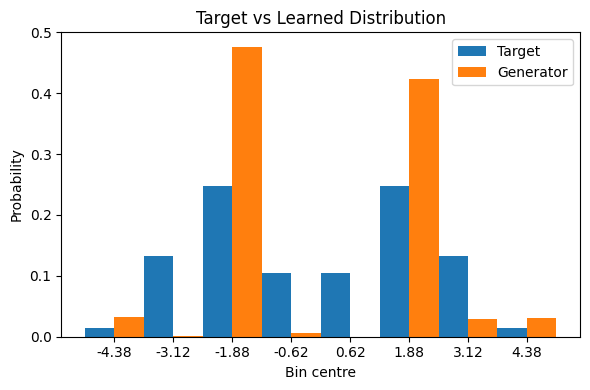

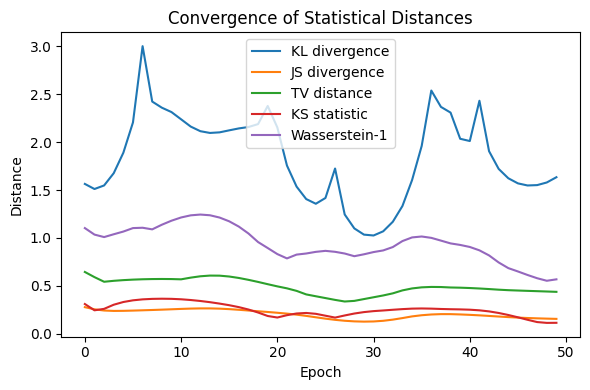

Final KL: 1.633396, JS: 0.156800, TV: 0.438644, KS: 0.115877, W1: 0.568985


In [16]:
import matplotlib.pyplot as plt

# Compute final generator probabilities
with torch.no_grad():
    final_probs = qnn_probs(1).squeeze(0).cpu().numpy()

# Assert generator probabilities form a valid distribution
assert np.isclose(final_probs.sum(), 1.0, atol=1e-3), "Generator probs must sum to 1"

# Sanity check: probabilities sum to 1
print(f"Final probs sum: {final_probs.sum():.6f}")

# Plot target vs learned distribution
plt.figure(figsize=(6, 4))
plt.bar(xs - bin_width/4, target_probs, width=bin_width/2, label='Target', align='center')
plt.bar(xs + bin_width/4, final_probs,  width=bin_width/2, label='Generator', align='center')
plt.xticks(xs, [f"{x:.2f}" for x in xs])
plt.xlabel('Bin centre')
plt.ylabel('Probability')
plt.title('Target vs Learned Distribution')
plt.legend()
plt.tight_layout()
plt.show()

# Plot statistical distances over epochs
epochs = np.arange(len(kls))
plt.figure(figsize=(6, 4))
plt.plot(epochs, kls, label='KL divergence')
plt.plot(epochs, jses, label='JS divergence')
plt.plot(epochs, tvs, label='TV distance')
plt.plot(epochs, kss, label='KS statistic')
plt.plot(epochs, wassersteins, label='Wasserstein-1')
plt.xlabel('Epoch')
plt.ylabel('Distance')
plt.title('Convergence of Statistical Distances')
plt.legend()
plt.tight_layout()
plt.show()

# Print final distance values
final_kl  = kl_divergence(target_probs, final_probs)
final_js  = js_divergence(target_probs, final_probs)
final_tv  = tv_distance(target_probs, final_probs)
final_ks  = ks_statistic(target_probs, final_probs)
final_w1  = wasserstein_distance(target_probs, final_probs, bin_width)
print(f"Final KL: {final_kl:.6f}, JS: {final_js:.6f}, TV: {final_tv:.6f}, KS: {final_ks:.6f}, W1: {final_w1:.6f}")


## 10. Conclusion and Outlook

So that's my little exploration of qGANs. Starting from the classical GAN picture, I discretised a continuous mixture of Gaussians onto a qubit grid, built a `RealAmplitudes` generator ansatz, wrapped it in a QNN with a `SamplerQNN` and `TorchConnector`, and trained it alongside a classical discriminator using PyTorch. By tracking a bunch of divergence metrics I could see if the generator was matching the target distribution. 

There are many ways to push this further. You can increase the number of qubits to represent higher‑resolution or higher‑dimensional distributions, try different ansätze like `EfficientSU2`, fiddle with learning rates or optimisers, or add tricks like gradient clipping. If you want to simulate hardware effects swap out the ideal `Sampler` for a shot‑based `AerSampler` and see how noise affects training. Another fun direction is to play with alternative loss functions, such as the Wasserstein loss with gradient penalty, which can improve stability. I'm still exploring these avenues and curious to hear how others fare.
